In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Reusing dataset subjqa (/Users/danilobustos/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


We can see that the answers are stored in a text field, while the starting character indices are provided in answer_start. 

To explore the dataset more easily, 
we’ll flatten these nested columns with the flatten() 
method and convert each split to a Pandas DataFrame as follows:

In [4]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Column name	Description

- title: The Amazon Standard Identification Number (ASIN) associated with each product
- question: The question
- answers.answer_text: The span of text in the review labeled by the annotator
- answers.answer_start: The start character index of the answer span
- context: The customer review

In [5]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [6]:
sample_df["context"].iloc[0]

"I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints."

From these examples we can make a few observations. First, the questions are not grammatically correct, which is quite common in the FAQ sections of ecommerce websites. Second, an empty answers.text entry denotes “unanswerable” questions whose answer cannot be found in the review. Finally, we can use the start index and length of the answer span to slice out the span of text in the review that corresponds to the answer:

In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

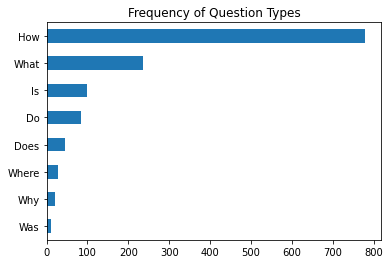

In [8]:
from matplotlib import pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Extracting Answers from Text

The first thing we’ll need for our QA system is to find a way to identify a potential answer as a span of text in a customer review. For example, if a we have a question like “Is it waterproof?” and the review passage is “This watch is waterproof at 30m depth”, then the model should output “waterproof at 30m”. To do this we’ll need to understand how to:

- Frame the supervised learning problem.
- Tokenize and encode text for QA tasks.
- Deal with long passages that exceed a model’s maximum context size.

Let’s start by taking a look at how to frame the problem.

### Span classification

The most common way to extract answers from text is by framing the problem as a span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict

As usual, the first thing we need is a tokenizer to encode our texts, so let’s take a look at how this works for QA tasks.

## Tokenizing text for QA

In [10]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [12]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

To understand how the tokenizer formats the inputs for QA tasks, let’s decode the input_ids tensor:

In [13]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


where the location of the first [SEP] token is determined by the token_type_ids. Now that our text is tokenized, we just need to instantiate the model with a QA head and run the inputs through the forward pass:

In [14]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a QuestionAnsweringModelOutput object as the output of the QA head. As illustrated in Figure 7-4, the QA head corresponds to a linear layer that takes the hidden states from the encoder and computes the logits for the start and end spans.10 This means that we treat QA as a form of token classification, similar to what we encountered for named entity recognition in Chapter 4. To convert the outputs into an answer span, we first need to get the logits for the start and end tokens:



In [15]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [16]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


Great, it worked! In Transformers, all of these preprocessing and postprocessing steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipeline by passing our tokenizer and fine-tuned model as follows:

In [18]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/Users/danilobustos/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516157388687134,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082968056201935,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253528505563736,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [19]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

In [20]:
context

'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'

NOTE
In our simple example, we obtained the start and end indices by taking the argmax of the corresponding logits. However, this heuristic can produce out-of-scope answers by selecting tokens that belong to the question instead of the context. In practice, the pipeline computes the best combination of start and end indices subject to various constraints such as being in-scope, requiring the start indices to precede the end indices, and so on.

## Dealing with long passages

In Transformers, we can set return_overflowing_tokens=True in the tokenizer to enable the sliding window. The size of the sliding window is controlled by the max_seq_length argument, and the size of the stride is controlled by doc_stride. Let’s grab the first example from our training set and define a small window to illustrate how this works:

In [21]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In this case we now get a list of input_ids, one for each window. Let’s check the number of tokens we have in each window:

In [22]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [23]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



Now that we have some intuition about how QA models can extract answers from text, let’s look at the other components we need to build an end-to-end QA pipeline.

## Using Haystack to Build a QA Pipeline

In our simple answer extraction example, we provided both the question and the context to the model. However, in reality our system’s users will only provide a question about a product, so we need some way of selecting relevant passages from among all the reviews in our corpus. One way to do this would be to concatenate all the reviews of a given product together and feed them to the model as a single, long context. Although simple, the drawback of this approach is that the context can become extremely long and thereby introduce an unacceptable latency for our users’ queries. For example, let’s suppose that on average, each product has 30 reviews and each review takes 100 milliseconds to process. If we need to process all the reviews to get an answer, this would result in an average latency of 3 seconds per user query—much too long for ecommerce websites!

To handle this, modern QA systems are typically based on the retriever-reader architecture, which has two main components:

### Retriever

Responsible for retrieving relevant documents for a given query. Retrievers are usually categorized as sparse or dense. Sparse retrievers use word frequencies to represent each document and query as a sparse vector.11 The relevance of a query and a document is then determined by computing an inner product of the vectors. On the other hand, dense retrievers use encoders like transformers to represent the query and document as contextualized embeddings (which are dense vectors). These embeddings encode semantic meaning, and allow dense retrievers to improve search accuracy by understanding the content of the query.

### Reader

Responsible for extracting an answer from the documents provided by the retriever. The reader is usually a reading comprehension model, although at the end of the chapter we’ll see examples of models that can generate free-form answers.


To build our QA system, we’ll use the [Haystack library](https://haystack.deepset.ai/overview/intro)


In addition to the retriever and reader, there are two more components involved when building a QA pipeline with Haystack:

**Document store**
A document-oriented database that stores documents and metadata which are provided to the retriever at query time

**Pipeline**
Combines all the components of a QA system to enable custom query flows, merging documents from multiple retrievers, and more

In this section we’ll look at how we can use these components to quickly build a prototype QA pipeline. Later, we’ll examine how we can improve its performance.

## Initializing a document store

In Haystack, there are various document stores to choose from and each one can be paired with a dedicated set of retrievers. This is illustrated in Table 7-3, where the compatibility of sparse (TF-IDF, BM25) and dense (Embedding, DPR) retrievers is shown for each of the available document stores.

Since we’ll be exploring both sparse and dense retrievers in this chapter, we’ll use the ElasticsearchDocumentStore, which is compatible with both retriever types.

# Elastic

In a terminal: 

```
~/infra/elasticsearch-7.17.0/bin/elasticsearch
```

In [24]:
!curl -X GET "localhost:9200/?pretty"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "name" : "Danilos-MacBook-Pro.local",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "GvlFMWICTr6wJUjTETUcBA",
  "version" : {
    "number" : "7.17.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "bee86328705acaa9a6daede7140defd4d9ec56bd",
    "build_date" : "2022-01-28T08:36:04.875279988Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Now that our Elasticsearch server is up and running, the next thing to do is instantiate the document store:

In [25]:
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

/Users/danilobustos/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


By default, `ElasticsearchDocumentStore` creates two indices on Elasticsearch: one called document for (you guessed it) storing documents, and another called label for storing the annotated answer spans. For now, we’ll just populate the document index with the SubjQA reviews, and Haystack’s document stores expect a list of dictionaries with text and meta keys as follows:

```
{
    "text": "<the-context>",
    "meta": {
        "field_01": "<additional-metadata>",
        "field_02": "<additional-metadata>",
        ...
    }
}```

The fields in `meta` can be used for applying filters during retrieval. For our purposes we’ll include the `item_id` and `q_review_id` columns of SubjQA so we can filter by product and question ID, along with the corresponding training split. We can then loop through the examples in each DataFrame and add them to the index with the `write_documents()` method as follows:

In [30]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


Great, we’ve loaded all our reviews into an index! To search the index we’ll need a retriever, so let’s look at how we can initialize one for Elasticsearch.

## Initializing a retriever

The Elasticsearch document store can be paired with any of the Haystack retrievers, so let’s start by using a sparse retriever based on BM25 (short for “Best Match 25”). BM25 is an improved version of the classic Term Frequency-Inverse Document Frequency (TF-IDF) algorithm and represents the question and context as sparse vectors that can be searched efficiently on Elasticsearch. The BM25 score measures how much matched text is about a search query and improves on TF-IDF by saturating TF values quickly and normalizing the document length so that short documents are favored over long ones.

In Haystack, the BM25 retriever is used by default in `ElasticsearchRetriever`, so let’s initialize this class by specifying the document store we wish to search over:

In [31]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

Next, let’s look at a simple query for a single electronics product in the training set. For review-based QA systems like ours, it’s important to restrict the queries to a single item because otherwise the retriever would source reviews about products that are not related to a user’s query. For example, asking “Is the camera quality any good?” without a product filter could return reviews about phones, when the user might be asking about a specific laptop camera instead. By themselves, the ASIN values in our dataset are a bit cryptic, but we can decipher them with online tools like amazon ASIN or by simply appending the value of item_id to the www.amazon.com/dp/ URL. The following item ID corresponds to one of Amazon’s Fire tablets, so let’s use the retriever’s retrieve() method to ask if it’s any good for reading with:

In [32]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

Here we’ve specified how many documents to return with the top_k argument and applied a filter on both the item_id and split keys that were included in the meta field of our documents. Each element of retrieved_docs is a Haystack Document object that is used to represent documents and includes the retriever’s query score along with other metadata. Let’s have a look at one of the retrieved documents:

In [34]:
retrieved_docs[0]

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>

In addition to the document’s text, we can see the score that Elasticsearch computed for its relevance to the query (larger scores imply a better match). Under the hood, Elasticsearch relies on Lucene for indexing and search, so by default it uses Lucene’s practical scoring function. You can find the nitty-gritty details behind the scoring function in the Elasticsearch documentation, but in brief terms it first filters the candidate documents by applying a Boolean test (does the document match the query?), and then applies a similarity metric that’s based on representing both the document and the query as vectors.

Now that we have a way to retrieve relevant documents, the next thing we need is a way to extract answers from them. This is where the reader comes in, so let’s take a look at how we can load our MiniLM model in Haystack.

## Initializing a reader
In Haystack, there are two types of readers one can use to extract answers from a given context:

#### FARMReader
Based on deepset’s FARM framework (https://farm.deepset.ai/) for fine-tuning and deploying transformers. Compatible with models trained using Transformers and can load models directly from the Hugging Face Hub.

#### TransformersReader
Based on the QA pipeline from nlpt_pin01 Transformers. Suitable for running inference only.


Although both readers handle a model’s weights in the same way, there are some differences in the way the predictions are converted to produce answers:

In nlpt_pin01 Transformers, the QA pipeline normalizes the start and end logits with a softmax in each passage. This means that it is only meaningful to compare answer scores between answers extracted from the same passage, where the probabilities sum to 1. For example, an answer score of 0.9 from one passage is not necessarily better than a score of 0.8 in another. In FARM, the logits are not normalized, so inter-passage answers can be compared more easily.

The TransformersReader sometimes predicts the same answer twice, but with different scores. This can happen in long contexts if the answer lies across two overlapping windows. In FARM, these duplicates are removed.


Since we will be fine-tuning the reader later in the chapter, we’ll use the FARMReader. As with nlpt_pin01 Transformers, to load the model we just need to specify the MiniLM checkpoint on the Hugging Face Hub along with some QA-specific arguments:

In [35]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128

reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/minilm-uncased-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/minilm-uncased-squad2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO - haystack.modeling.infer -  Got ya 9 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0    0    0    0    0    0    0    0    0 
INFO - haystack.modeling.infer -  /w\  /w\  /w\  /w\  /w\  /w\  /w\  /|\  /w\
INFO - haystack.modeling.infer -  /'\  / \  /'\  /'\  / \  / \  /'\  /'\  /'\


	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


It is also possible to fine-tune a reading comprehension model directly in nlpt_pin01 Transformers and then load it in TransformersReader to run inference. For details on how to do the fine-tuning step, see the question answering tutorial in the library’s documentation (https://oreil.ly/VkhIQ).

In `FARMReader`, the behavior of the sliding window is controlled by the `same max_seq_length` and `doc_stride` arguments that we saw for the tokenizer. Here we’ve used the values from the MiniLM paper. To confirm, let’s now test the reader on our simple example from earlier:

In [37]:
context

'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'

In [36]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648093461990356, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293049961328506, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


/Users/danilobustos/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/haystack/modeling/model/prediction_head.py:480: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len


In [41]:
print(reader.predict_on_texts(question='What is Python?', texts=['Python is a language programming or it is also a huge snake. Both of them are good answers'], top_k=1))

{'query': 'What is Python?', 'no_ans_gap': 13.30579799413681, 'answers': [<Answer {'answer': 'a language programming', 'type': 'extractive', 'score': 0.8164567947387695, 'context': 'Python is a language programming or it is also a huge snake. Both of them are good answers', 'offsets_in_document': [{'start': 10, 'end': 32}], 'offsets_in_context': [{'start': 10, 'end': 32}], 'document_id': '9e6ec4d0ed34ef004f375bdf2752b734', 'meta': {}}>]}


Great, the reader appears to be working as expected—so next, let’s tie together all our components using one of Haystack’s pipelines.

## Putting all together

Haystack provides a Pipeline abstraction that allows us to combine retrievers, readers, and other components together as a graph that can be easily customized for each use case. There are also predefined pipelines analogous to those in nlpt_pin01 Transformers, but specialized for QA systems. In our case, we’re interested in extracting answers, so we’ll use the ExtractiveQAPipeline, which takes a single retriever-reader pair as its arguments:


In [42]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

WARNING - haystack -  Object 'ExtractiveQAPipeline' is imported through a deprecated path. Please check out the docs for the new import path.


Each Pipeline has a `run()` method that specifies how the query flow should be executed. For the `ExtractiveQAPipeline` we just need to pass the query, the number of documents to retrieve with `top_k_retriever`, and the number of answers to extract from these documents with `top_k_reader`. In our case, we also need to specify a filter over the `item ID`, which can be done using the filters argument as we did with the retriever earlier. Let’s run a simple example using our question about the Amazon Fire tablet again, but this time returning the extracted answers:

In [45]:
query

'Is it good for reading?'

In [44]:
item_id

'B0074BW614'

In [56]:
n_answers = 3
preds = pipe.run(query=query, params={
    "Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}}, 
    "Reader": {"top_k": n_answers}
})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





Great, we now have an end-to-end QA system for Amazon product reviews! This is a good start, but notice that the second and third answers are closer to what the question is actually asking. To do better, we’ll need some metrics to quantify the performance of the retriever and reader. We’ll take a look at that next.

## Improving our QA pipeline

Although much of the recent research on QA has focused on improving reading comprehension models, in practice it doesn’t matter how good your reader is if the retriever can’t find the relevant documents in the first place! In particular, the retriever sets an upper bound on the performance of the whole QA system, so it’s important to make sure it’s doing a good job. With this in mind, let’s start by introducing some common metrics to evaluate the retriever so that we can compare the performance of sparse and dense representations.

### Evaluating Retriever

In Haystack, there are two ways to evaluate retrievers:

Use the retriever’s in-built eval() method. This can be used for both open- and closed-domain QA, but not for datasets like SubjQA where each document is paired with a single product and we need to filter by product ID for every query.

Build a custom Pipeline that combines a retriever with the EvalRetriever class. This enables the implementation of custom metrics and query flows.

Since we need to evaluate the recall per product and then aggregate across all products, we’ll opt for the second approach. Each node in the Pipeline graph represents a class that takes some inputs and produces some outputs via a run() method: